# Portfolio Rebalancing Strategy

## Select a list of stocks first
## After each month select only 6 stocks that has provided highest return
## Repeat the selection process

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import datetime as dt
import yfinance as yf
import copy

In [25]:
def CAGR(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["mon_ret"]).cumprod()
    n=len(df)/12 #252 trading days #252*8 trading hours   #
    CAGR=(df["cum_return"].tolist()[-1])**(1/n) -1
    return CAGR

In [26]:
def volatility(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    vol=df["mon_ret"].std()*np.sqrt(12)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [27]:
def sharpe(DF,rf):
    df=DF.copy()
    return ((CAGR(df)-rf)/volatility(df))

In [28]:
def max_dd(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["mon_ret"]).cumprod()
    df["cum_roll_max"]=df["cum_return"].cummax()
    df["drawdown"]=df["cum_roll_max"]-df["cum_return"]
    df["drawdown_pct"]=df["drawdown"]/df["cum_roll_max"]
    return df["drawdown_pct"].max()

In [29]:
def calmar(DF):
    df=DF.copy()
    return CAGR(df)/max_dd(DF)

In [30]:
tickers=["AAPL","TSLA","AMD","NVDA","TWTR","HP","AMZN","XOM","MSFT"]

In [31]:
ohlc_mon={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(3650)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_mon[ticker]=yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")

tickers=ohlc_mon.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
tickers

dict_keys(['AAPL', 'TSLA', 'AMD', 'NVDA', 'TWTR', 'HP', 'AMZN', 'XOM', 'MSFT'])

In [33]:
#calculating monthly return for each stock and consolidating return info by stock in a seperate dataframe
ohlc_dict=copy.deepcopy(ohlc_mon)
return_df=pd.DataFrame()

for ticker in tickers:
    print("Calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"]=ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker]=ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

Calculating monthly return for  AAPL
Calculating monthly return for  TSLA
Calculating monthly return for  AMD
Calculating monthly return for  NVDA
Calculating monthly return for  TWTR
Calculating monthly return for  HP
Calculating monthly return for  AMZN
Calculating monthly return for  XOM
Calculating monthly return for  MSFT


In [34]:
return_df

,AAPL,TSLA,AMD,NVDA,TWTR,HP,AMZN,XOM,MSFT
Date,,,,,,,,,
2014-01-01,-0.107697,0.205943,-0.113695,-0.019975,0.013354,0.047098,-0.100554,-0.089328,0.011494
2014-02-01,0.051218,0.349485,0.081633,0.170701,-0.148682,0.121649,0.009507,0.044596,0.012421
2014-03-01,0.026059,-0.148523,0.080863,-0.021172,-0.150064,0.096998,-0.071058,0.021833,0.077978
2014-04-01,0.099396,-0.002687,0.019950,0.031268,-0.164988,0.010134,-0.095847,0.048423,-0.014394
2014-05-01,0.072718,-0.000577,-0.022005,0.028695,-0.167565,0.011965,0.027685,-0.018358,0.013366
...,...,...,...,...,...,...,...,...,...
2022-07-01,0.188634,0.323765,0.235386,0.198419,0.112864,0.075244,0.270596,0.131831,0.093097
2022-08-01,-0.032552,-0.072489,-0.101620,-0.168970,-0.068733,-0.076674,-0.060615,-0.013824,-0.068640
2022-09-01,-0.119756,-0.037589,-0.253446,-0.195773,0.131355,-0.130019,-0.108622,-0.077745,-0.107376


In [35]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """
    Returns cumulative portfolio return
    DF=dataframe with monthly return info for all stocks
    m=number of stock in the portfolio
    x=number of underperforming stocks to be removed from portfolio monthly
    """
    df=DF.copy()
    portfolio=[]
    monthly_ret=[0]
    
    for i in range(len(df)):
        if len(portfolio)>0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks=df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio=[t for t in portfolio if t not in bad_stocks]
        fill=m-len(portfolio)
        #new_picks=df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        new_picks=df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist() #with replacement
        portfolio=portfolio+new_picks
        print(portfolio)
    monthly_ret_df=pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    
    return monthly_ret_df

In [36]:
pflio(return_df,6,3)

['TSLA', 'HP', 'TWTR', 'MSFT', 'NVDA', 'XOM']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'MSFT', 'TSLA']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'MSFT', 'XOM', 'AMZN']
['NVDA', 'AAPL', 'XOM', 'MSFT', 'TSLA', 'AMZN']
['NVDA', 'AAPL', 'AMZN', 'MSFT', 'TSLA', 'TWTR']
['NVDA', 'AAPL', 'MSFT', 'XOM', 'HP', 'AMD']
['NVDA', 'AAPL', 'AMD', 'AMZN', 'TWTR', 'XOM']
['NVDA', 'AMD', 'TWTR', 'HP', 'AAPL', 'MSFT']
['TWTR', 'HP', 'AAPL', 'AMZN', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'MSFT', 'XOM']
['AMZN', 'NVDA', 'TSLA', 'AAPL', 'AMD', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'MSFT', 'NVDA', 'AAPL']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'MSFT', 'TSLA', 'AAPL']
['AMZN', 'NVDA', 'MSFT

,mon_ret
0,0.000000
1,0.091695
2,0.009343
3,0.032463
4,0.012073
...,...
102,0.186798
103,-0.075012
104,-0.053289
105,0.065985


# calculating overall strategy's KPIs

In [37]:
CAGR(pflio(return_df,6,3))

['TSLA', 'HP', 'TWTR', 'MSFT', 'NVDA', 'XOM']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'MSFT', 'TSLA']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'MSFT', 'XOM', 'AMZN']
['NVDA', 'AAPL', 'XOM', 'MSFT', 'TSLA', 'AMZN']
['NVDA', 'AAPL', 'AMZN', 'MSFT', 'TSLA', 'TWTR']
['NVDA', 'AAPL', 'MSFT', 'XOM', 'HP', 'AMD']
['NVDA', 'AAPL', 'AMD', 'AMZN', 'TWTR', 'XOM']
['NVDA', 'AMD', 'TWTR', 'HP', 'AAPL', 'MSFT']
['TWTR', 'HP', 'AAPL', 'AMZN', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'MSFT', 'XOM']
['AMZN', 'NVDA', 'TSLA', 'AAPL', 'AMD', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'MSFT', 'NVDA', 'AAPL']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'MSFT', 'TSLA', 'AAPL']
['AMZN', 'NVDA', 'MSFT

0.3168384376866482

In [38]:
sharpe(pflio(return_df,6,3),0.025)

['TSLA', 'HP', 'TWTR', 'MSFT', 'NVDA', 'XOM']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'MSFT', 'TSLA']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'MSFT', 'XOM', 'AMZN']
['NVDA', 'AAPL', 'XOM', 'MSFT', 'TSLA', 'AMZN']
['NVDA', 'AAPL', 'AMZN', 'MSFT', 'TSLA', 'TWTR']
['NVDA', 'AAPL', 'MSFT', 'XOM', 'HP', 'AMD']
['NVDA', 'AAPL', 'AMD', 'AMZN', 'TWTR', 'XOM']
['NVDA', 'AMD', 'TWTR', 'HP', 'AAPL', 'MSFT']
['TWTR', 'HP', 'AAPL', 'AMZN', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'MSFT', 'XOM']
['AMZN', 'NVDA', 'TSLA', 'AAPL', 'AMD', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'MSFT', 'NVDA', 'AAPL']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'MSFT', 'TSLA', 'AAPL']
['AMZN', 'NVDA', 'MSFT

1.1337072892329063

In [39]:
max_dd(pflio(return_df,6,3))

['TSLA', 'HP', 'TWTR', 'MSFT', 'NVDA', 'XOM']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'MSFT', 'TSLA']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'MSFT', 'XOM', 'AMZN']
['NVDA', 'AAPL', 'XOM', 'MSFT', 'TSLA', 'AMZN']
['NVDA', 'AAPL', 'AMZN', 'MSFT', 'TSLA', 'TWTR']
['NVDA', 'AAPL', 'MSFT', 'XOM', 'HP', 'AMD']
['NVDA', 'AAPL', 'AMD', 'AMZN', 'TWTR', 'XOM']
['NVDA', 'AMD', 'TWTR', 'HP', 'AAPL', 'MSFT']
['TWTR', 'HP', 'AAPL', 'AMZN', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'MSFT', 'XOM']
['AMZN', 'NVDA', 'TSLA', 'AAPL', 'AMD', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'MSFT', 'NVDA', 'AAPL']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'MSFT', 'TSLA', 'AAPL']
['AMZN', 'NVDA', 'MSFT

0.3055555621089261

# calculating KPIs for Index buy and hold strategy over the same period

In [40]:
DJI=yf.download("^DJI",start=dt.date.today()-dt.timedelta(3650),end=dt.date.today(),interval='1mo')
DJI["mon_ret"]=DJI["Adj Close"].pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [41]:
DJI

,Open,High,Low,Close,Adj Close,Volume,mon_ret
Date,,,,,,,
2012-11-01,13099.190430,13290.750000,12471.490234,13025.580078,13025.580078,2683930000,0.000000
2012-12-01,13027.730469,13365.860352,12883.889648,13104.139648,13104.139648,2666750000,0.006031
2013-01-01,13104.299805,13969.990234,13104.299805,13860.580078,13860.580078,2786680000,0.057725
2013-02-01,13860.580078,14149.150391,13784.009766,14054.490234,14054.490234,2487580000,0.013990
2013-03-01,14054.490234,14585.099609,13937.599609,14578.540039,14578.540039,2546320000,0.037287
...,...,...,...,...,...,...,...
2022-06-01,33156.308594,33272.339844,29653.289062,30775.429688,30775.429688,7655170000,-0.067132
2022-07-01,30737.769531,32910.179688,30143.929688,32845.128906,32845.128906,6354530000,0.067252
2022-08-01,32755.710938,34281.359375,31509.589844,31510.429688,31510.429688,6960090000,-0.040636


In [42]:
CAGR(DJI)

0.09232235785282494

In [43]:
sharpe(DJI,0.025)

0.46661305487287386

In [44]:
max_dd(DJI)

0.23201266165063414

In [45]:
volatility(DJI)

0.144278770492537

# Visualization

['TSLA', 'HP', 'TWTR', 'MSFT', 'NVDA', 'XOM']
['TSLA', 'HP', 'NVDA', 'AMD', 'AAPL', 'XOM']
['HP', 'AMD', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AAPL', 'XOM', 'NVDA', 'AMD', 'HP', 'TSLA']
['AAPL', 'NVDA', 'HP', 'AMZN', 'MSFT', 'TSLA']
['HP', 'AMZN', 'TSLA', 'TWTR', 'AMD', 'AAPL']
['AMZN', 'TWTR', 'AAPL', 'MSFT', 'XOM', 'NVDA']
['AMZN', 'TWTR', 'NVDA', 'TSLA', 'AAPL', 'AMD']
['TWTR', 'NVDA', 'AAPL', 'MSFT', 'XOM', 'AMZN']
['NVDA', 'AAPL', 'XOM', 'MSFT', 'TSLA', 'AMZN']
['NVDA', 'AAPL', 'AMZN', 'MSFT', 'TSLA', 'TWTR']
['NVDA', 'AAPL', 'MSFT', 'XOM', 'HP', 'AMD']
['NVDA', 'AAPL', 'AMD', 'AMZN', 'TWTR', 'XOM']
['NVDA', 'AMD', 'TWTR', 'HP', 'AAPL', 'MSFT']
['TWTR', 'HP', 'AAPL', 'AMZN', 'XOM', 'NVDA']
['HP', 'AMZN', 'NVDA', 'TSLA', 'MSFT', 'XOM']
['AMZN', 'NVDA', 'TSLA', 'AAPL', 'AMD', 'XOM']
['AMZN', 'TSLA', 'AMD', 'TWTR', 'XOM', 'HP']
['AMZN', 'TSLA', 'XOM', 'MSFT', 'NVDA', 'AAPL']
['AMZN', 'XOM', 'NVDA', 'HP', 'AMD', 'TSLA']
['AMZN', 'XOM', 'NVDA', 'MSFT', 'TSLA', 'AAPL']
['AMZN', 'NVDA', 'MSFT

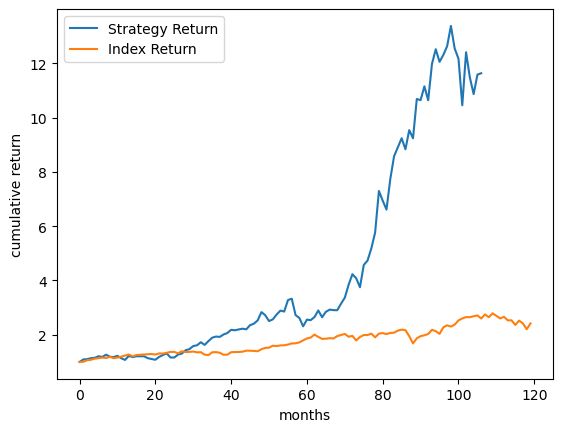

In [46]:
fig,ax=plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])